# Mobility Patterns

#### Script to examine patterns in mobility data.

For any individual device, there will be places that are significant for that device that are visited very regularly. You can imagine that such places may represent home, work or other places of interest to the device in question. The dataset has been transposed from its original location, so it will be more beneficial to focus on finding these locations of significance from within the data as opposed to doing so by associating it with an external dataset.
The patterns of movement to and from these places will vary in a range of dimensions, including, but not limited to:
- Frequency
- Distance
- Duration
- Direction

The task for this is to begin the exploration of these patterns. We would like you to work on the following:
- Find unsupervised classifications of groups of users based upon the mobility patterns, as partially characterised above, that can be extracted from this dataset. In order to achieve this, you will need to identify the frequently visited places, as mentioned above for each device.
- We provide two samples from two months - one pre-pandemic and one during the pandemic. As a stretch task, you could look at how these patterns may have changed as behaviour shifted into the pandemic.

#### Code aims to find behavioural patterns for each device.

Things to note:
- No single best clustering algorithm for all cases
- Explore a range of clustering algorithms on smaller dataset
- Different configurations for each algorithm allow for an interative process
- There is no one error metric to evaluate how well unsupervised clustering algorithms perform
- Affinity Propagation is particularly suited to when we do not know the number of clusters needed
- Affinity Propagation most appropriate for small to medium sized datasets so use this to initially find cluster amounts
- Use more appropriate algorithm once n_clusters is estimated from exploration
- Further exploration found that MiniBatchKMeans was both efficient and produced a sensible clustering

## Import Libraries

In [1]:
##General
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import time
from datetime import datetime
import warnings

##Geospatial
from osgeo import gdal, osr, ogr #For gdal spatial manipulation
import geopandas as gpd #For shapefile manipulation
from shapely.geometry import mapping, point #For changing shapely geometries

##Machine Learning
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn import cluster, mixture, metrics
from sklearn.cluster import AffinityPropagation
from sklearn.neighbors import kneighbors_graph
import itertools
from itertools import cycle, islice

##Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

## Read the data

In [2]:
##Prepandemic data
prepan = pd.read_csv('./Data/huq-evaluation-samples/huq-evaluation-sample-01.csv')

##Pandemic data
pan = pd.read_csv('./Data/huq-evaluation-samples/huq-evaluation-sample-02.csv')

## Data Exploration

### Function for data exploration

- Function to understand the type, shape and unique aspects of the dataset.
- Input is a dataframe object.
- Returns summary information on the dataset and a graph of the location of the devices at different timestamps

In [3]:
## Load function
def data_exploration(data):

    ##Shape of data
    print('Shape:')
    print(data.shape)

    ##Type of data
    print('\nType:')
    print(data.dtypes)

    ##Head to see data
    print('\nHead:')
    print(data.head)

    ##Unique devices
    print('\nUnique Devices:')
    print(data['device'].describe())

    ##Unique coordinates
    print('\nUnique Coordinates:')
    print(data[['latitude', 'longitude']].nunique())

    ##Contains NaN
    print('\nContains NaN:')
    print(data.isnull().values.any())

    #Create a scatter plot to visualise coordinates
    plt.scatter(prepan["longitude"], prepan["latitude"])
    plt.title("Scatter plot showing location of devices")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

### Explore prepandemic and pandemic data

Shape:
(4553164, 4)

Type:
device        object
timestamp     object
latitude     float64
longitude    float64
dtype: object

Head:
<bound method NDFrame.head of                            device                timestamp  latitude  \
0        NpKqpyO4YqKutQHwaflt/A==  2020-01-01 18:53:20 UTC   46.7740   
1        NeAr5D2RxmV7nG7ZXM8HDA==  2020-01-01 18:53:20 UTC   45.1140   
2        N2J0fh21MUty7Po+U0Gi4Q==  2020-01-01 18:53:20 UTC   46.6360   
3        NWge8EpoClC/KdRDh6CHqA==  2020-01-01 18:53:20 UTC   46.9750   
4        NA5NhD/330Q/OooX4wvMjg==  2020-01-02 04:53:20 UTC   46.3143   
...                           ...                      ...       ...   
4553159  2LKVsb6it+4bZCP5kH3NjA==  2020-01-30 15:50:05 UTC   45.7562   
4553160  4yaDzDbmjfLyJxuvj1E0vQ==  2020-01-29 18:01:19 UTC   48.2257   
4553161  Bp21nJY8/ui6ISCAZ7BBzQ==  2020-01-02 15:57:22 UTC   45.8430   
4553162  DT5tUyYl+yJ+YBPzBnzBYg==  2020-01-09 10:25:10 UTC   46.4555   
4553163  4NoytduOLMJhnHz9mgInFA==  2020-01-07 

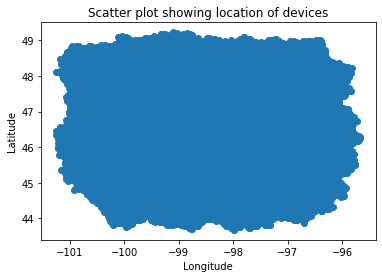

In [4]:
##Run function on prepandemic data
data_exploration(prepan)

Shape:
(4933272, 4)

Type:
device        object
timestamp     object
latitude     float64
longitude    float64
dtype: object

Head:
<bound method NDFrame.head of                            device                timestamp  latitude  \
0        YXRYkUO1i5ta5MsOfTRU0g==  2021-01-02 00:26:40 UTC   46.8890   
1        XMfPOzEEPDCRJfwaRHN3Qg==  2021-01-02 00:26:40 UTC   48.3463   
2        Yr7PGB8iy2gwlXOaz3zrpQ==  2021-01-03 21:26:40 UTC   46.1586   
3        YtrhYD5VNoXBLMOyCBPnTw==  2021-01-03 21:26:40 UTC   47.9106   
4        YI8dstvWw+RRSOq6jBQcDw==  2021-01-04 01:53:20 UTC   45.9771   
...                           ...                      ...       ...   
4933267  /bsOObH7DFM6LYSvgEWR+w==  2021-01-25 15:11:37 UTC   46.1991   
4933268  A8OWhVLAXiZG2xXOIDHkjw==  2021-01-19 11:51:03 UTC   48.1995   
4933269  B7MOM0rQlocj+Bpg79oJ1w==  2021-01-28 20:54:07 UTC   47.7392   
4933270  Ti88yqtgGk9BkI7lCV/y5A==  2021-01-31 07:57:25 UTC   46.8428   
4933271  DqApFEgyJe+dL1aLqLFavw==  2021-01-19 

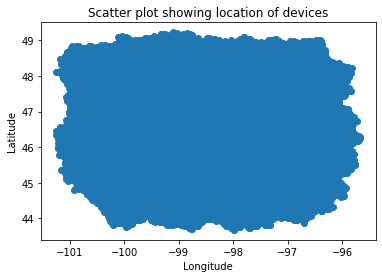

In [5]:
##Run function on pandemic data
data_exploration(pan)

Findings:
- Exploration shows the datasets are of different shapes and contain NaN's so need to be cleaned
- Exploration shows there is a difference in datatypes which should be considered
- Choice to remove NaN rather than interpolate the values using mean etc as working with a relatively unknown dataset
- The number of unique devices stays the same between datasets
- There are more device timestamps during the pandemic

## Data Cleaning and Manipulation

### Function to sample data for testing

In [6]:
##Function to sample data
def sampling(data):
    
    #Remove NaN
    data = data.dropna()

    #Sample a smaller batch of the dataset
    data_sample = data.sample(10000, axis = 0)
    
    return data_sample

### Functions for cleaning and manipulating the data for testing

- Input is a dataframe object.
- Returns clean test datasets

Functions find:
- Unique places that each device has visited
- Distance the device travelled between locations
- Duration the device has spent at a location in a day
- Direction device has travelled

In [7]:
##Function to calculate frequently visted places
def frequent_visits(data):
    
    #Unique places that each device has visited
    unique_places = data.groupby(['device', 'latitude', 'longitude']).size().to_frame('freq').reset_index()
    
    #Extract features and labels
    X = unique_places[['longitude', 'latitude', 'freq']]
    y = unique_places['device']
    
    #Number of unique places
    print("Number of unique places: " + str(len(X)))

    return X, y

In [8]:
##Function to find greater circle distance travelled by devices
def distance_travelled(data):

    #Function to calculate Haversine distance between subsequent points in radians
    def haversine(lat1, lon1, lat2, lon2, earth_radius=6371):

        #Convert to radians
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        #Calculate haversine distance
        a = np.sin((lat2-lat1)/2.0)**2 + \
            np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

        #Return distance in km
        return earth_radius * 2 * np.arcsin(np.sqrt(a))

    #Sort data by device and timestamp
    data = data.sort_values(['device', 'timestamp'], ascending=True)

    #Calculate distance between timestamps for each device
    def for_each_device(devices):

        #Per device
        sample_device = data[data['device'] == devices]

        #Retain timestamp order
        sample_device = sample_device.sort_values(['timestamp'], ascending=True)

        #Calculate haversine distance
        distances = list(haversine(sample_device.latitude.shift(), sample_device.longitude.shift(), sample_device['latitude'][1:], sample_device['longitude'][1:]))

        return distances

    #Create list of distances and add to data.frame
    distance_list = [for_each_device(devices) for devices in data['device'].unique()]
    data['distance'] = [x for xs in distance_list for x in xs] 

    #Calculate the mean, mininmum and maximum distance travelled
    data = data.groupby(['device'])['distance'].agg([np.mean, np.min, np.max]).reset_index()

    #Rename columns and drop na
    data = data.rename(columns={'mean': 'mean_distance', 'amin': 'minimum_distance', 'amax': 'maximum_distance'}).dropna()
    
    #Extract features and labels
    X = data[['mean_distance', 'minimum_distance', 'maximum_distance']]
    y = data['device']

    return X, y


In [9]:
##Function to find duration spent at location in a day
def duration_spent(data):

    #Convert to datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    #Add date
    data['date'] = data['timestamp'].dt.date

    #Sort data by device and timestamp
    data = data.sort_values(['device', 'timestamp'], ascending=True)

    #Calculate duration spent at location in same day
    data['duration'] = data.groupby(['device', 'latitude', 'longitude', 'date'])['timestamp'].diff()

    #Extract timedelta in minutes  
    data['duration'] = data['duration'] / np.timedelta64(1, 'm')

    #Duration
    duration = data[['device', 'latitude', 'longitude', 'duration']].dropna()

    #Extract features and labels
    X = duration[['longitude', 'latitude', 'duration']]
    y = duration['device']

    return X, y

In [10]:
##Function to calculate direction of travel
def travel_direction(data):
    
    #Calculate direction from coordinates
    def direction_lookup(origin_y, origin_x, destination_y, destination_x):

        #Calculate delta
        deltaX = destination_x - origin_x
        deltaY = destination_y - origin_y

        #Combine
        combined = pd.concat([deltaX, deltaY], axis = 1)

        #For each coordinate delta
        def for_each_coordinate(i):

            # Calculate degrees
            degrees_temp = math.atan2(np.array(combined.iloc[i][0]), np.array(combined.iloc[i][1]))/math.pi*180
            if degrees_temp < 0:
               degrees_final = 360 + degrees_temp
            else:
               degrees_final = degrees_temp

            #If NA put 0
            if math.isnan(degrees_final):
               degrees_final = 0

            #Return direction on compass
            compass_brackets = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
            compass_lookup = round(degrees_final/45)
            return(compass_brackets[compass_lookup], degrees_final)

        return [for_each_coordinate(i) for i in range(0, len(combined))]

    #Calculate directions between timestamps for each device
    def for_each_device(devices):

        #Per device
        sample_device = data[data['device'] == devices]

        #Retain timestamp order
        sample_device = sample_device.sort_values(['timestamp'], ascending=True)

        #Calculate compass direction
        directions = list(direction_lookup(sample_device.latitude.shift(), sample_device.longitude.shift(), sample_device['latitude'][1:], sample_device['longitude'][1:]))

        return directions

    #Create list of directions and add to data.frame
    direction_list = [for_each_device(devices) for devices in data['device'].unique()]
    data['directions'] = [x for xs in direction_list for x in xs] 

    #Sort data
    data = data.sort_values(['device', 'timestamp'], ascending=True)

    #Remove blank data
    data['directions'] = data['directions'].replace(['(N, 0.0)'], np.nan).dropna()
    data['directions'] = data['directions'].replace(['(N, 0)'], np.nan).dropna()
    
    #Split tuple
    data[['directions', 'degrees']] = pd.DataFrame(data['directions'].tolist(), index=data.index)

    #Extract features and labels
    X = data[['degrees']]
    y = data['device']

    return X, y

As I don't know the number of clusters for each behavioural pattern I can use affinity propogation to estimate the number. So I need to create a function that runs affinity propogation on the data.

### Function for running affinity propogation multiple times

- Run multiple times to then take an average of the cluster numbers
- Input is dataframe object.
- Returns estimated number of clusters.

In [11]:
#Run affinity propogation on features
def run_ap_samples(X):
    
    #Drop NA
    X = X.dropna()

    #Convert to array
    X = np.array(X)

    #Scale
    X = StandardScaler().fit_transform(X)

    #Affinity Propagation
    af = AffinityPropagation(damping=0.9).fit(X)

    #Extract cluster indices
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    #Number of clusters
    n_clusters_ = len(cluster_centers_indices)

    return(n_clusters_)

## Exploring different cluster algorithms

As there is no best algorithm for all data, I need to explore how different algorithms perform on a subset of the data.

### Function to explore different clustering algorithms

- Input is a feature set (X) and labels (y)
- Returns a graph displaying each algorithm and its success
- Mimicing the sklearn exploratory graph code

In [12]:
##Load function
def algorithm_exploration(X, y, coordinates = False):

    #Use affinity propogation to estimate cluster numbers
    print('Estimating Cluster Numbers Using Affinity Propagation')
    cluster_list = []
    for _ in tqdm(range(5)):
        cluster_list.append(run_ap_samples(X))

    print('Exploring Different Algorithms')

    #Remove NaN
    cluster_list = np.array(cluster_list)
    cluster_list = cluster_list[~np.isnan(cluster_list)]

    #Plot parameters
    plt.figure(figsize=(9 * 2 + 3, 6))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )
    plot_num = 1

    #Baseline algorithm parameters
    algo_params = {"quantile": 0.3,
                   "eps": 0.3,
                   "damping": 0.9,
                   "preference": -200,
                   "n_neighbors": 3,
                   "n_clusters": int(np.mean(cluster_list).round()), #Use mean of AP to get cluster numbers
                   "min_samples": 7,
                   "xi": 0.05,
                   "min_cluster_size": 0.1
                   }

    #Update parameters with dataset-specific values
    params = algo_params
    
    #Drop NA
    X = X.dropna()

    #Convert to array
    X = np.ascontiguousarray(X)

    #Normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    #Estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    #Connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    ##Make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    ##Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in tqdm(clustering_algorithms):
        t0 = time.time()

        ##Catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(np.ascontiguousarray(X))

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
            
        #If not coordinates decompose features to two dimensions for plotting
        if coordinates == False: 
            # Embed the data set in 2 dimensions using the fitted model
            pca = PCA(n_components = 2)
            X = pca.fit_transform(X)

        plt.subplot(1, len(clustering_algorithms), plot_num)
        plt.title(name, size=18)

        #Set colors
        colors = sns.color_palette("Spectral", n_colors = int(np.mean(cluster_list).round())).as_hex()
        #Add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

    plt.show()

### Exploring algorithms on different behavioural patterns in pre-pandemic data

- Exploring each behavioural pattern
- Only using prepandemic data for testing and exploring the algorithms

Number of unique places: 6946
Estimating Cluster Numbers Using Affinity Propagation


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:09<00:00, 97.91s/it]


Exploring Different Algorithms


 33%|██████████████████████████████                                                            | 3/9 [00:14<00:39,  6.56s/it]/Users/rossgray/anaconda3/envs/Huq/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:279: UserWarning: the number of connected components of the connectivity matrix is 102 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
 44%|████████████████████████████████████████                                                  | 4/9 [00:17<00:24,  4.85s/it]/Users/rossgray/anaconda3/envs/Huq/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:549: UserWarning: the number of connected components of the connectivity matrix is 102 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
100%|██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.30s/it]


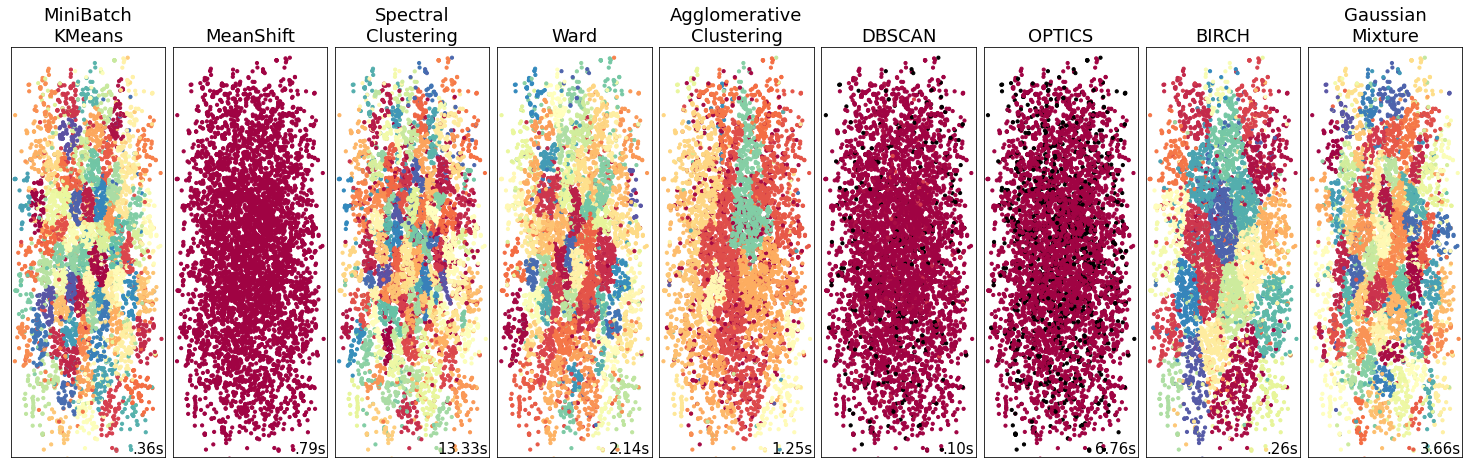

In [13]:
##Frequently Vistited Places
#Sample data
data_sample = sampling(prepan)

#Find places
X, y = frequent_visits(data_sample)

#Explore
algorithm_exploration(X, y, coordinates = True)

Estimating Cluster Numbers Using Affinity Propagation


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.63s/it]


Exploring Different Algorithms


 56%|██████████████████████████████████████████████████                                        | 5/9 [00:03<00:02,  1.67it/s]/Users/rossgray/anaconda3/envs/Huq/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
 78%|██████████████████████████████████████████████████████████████████████                    | 7/9 [00:04<00:01,  1.60it/s]/Users/rossgray/anaconda3/envs/Huq/lib/python3.10/site-packages/sklearn/cluster/_birch.py:747: ConvergenceWarning: Number of subclusters found (35) by BIRCH is less than (138). Decrease the threshold.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.45it/s]


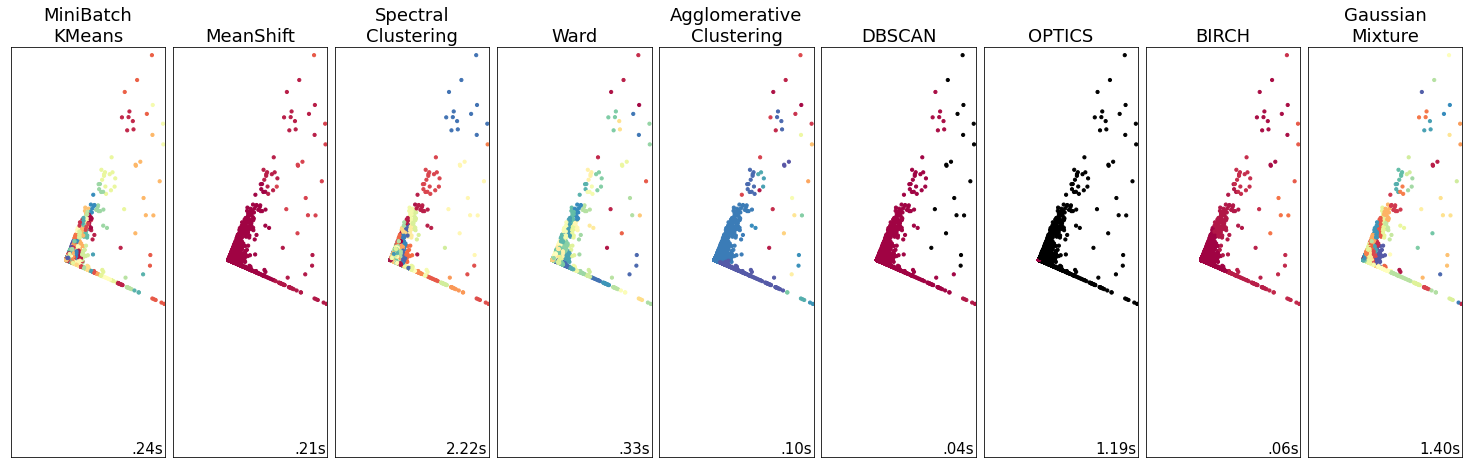

In [14]:
##Distance travelled
#Sample data
data_sample = sampling(prepan)

#Calculate distance
X, y = distance_travelled(data_sample)

#Explore
algorithm_exploration(X, y, coordinates = False)

Estimating Cluster Numbers Using Affinity Propagation


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


Exploring Different Algorithms


100%|██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.41it/s]


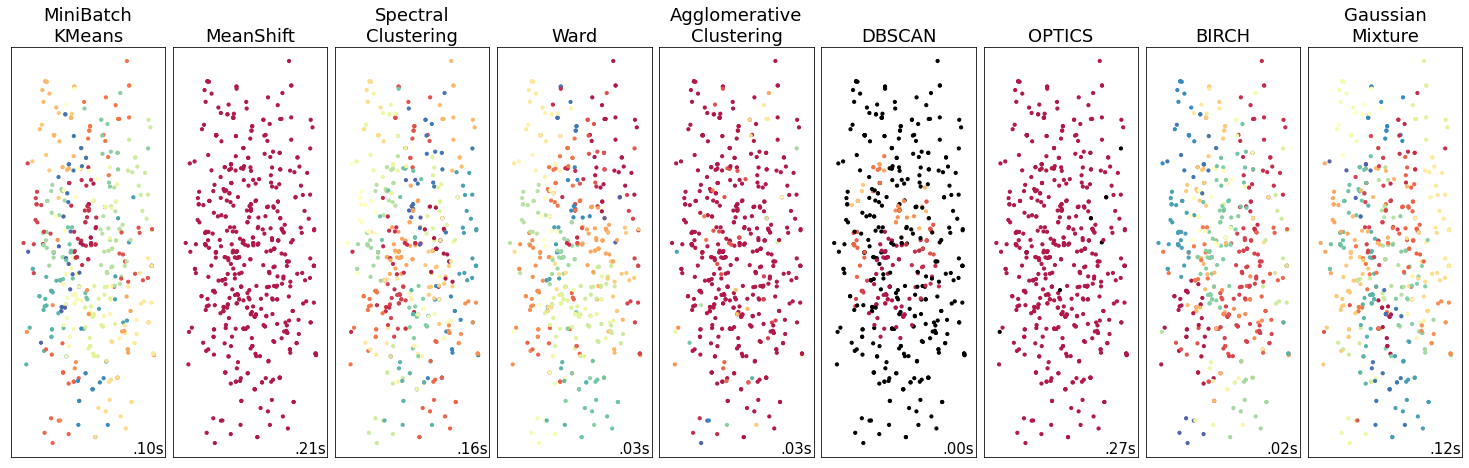

In [15]:
##Duration spent
#Sample data
data_sample = sampling(prepan)

#Calculate duration
X, y = duration_spent(data_sample)

#Explore
algorithm_exploration(X, y, coordinates = True)

In [16]:
# ##Direction of travel
# #Sample data
# data_sample = sampling(prepan)

# #Find direction
# X, y = travel_direction(data_sample)

# #Explore
# algorithm_exploration(X, y, coordinates = False)

- Results of the exploration show that many of the algorithms over cluster the data points or there are issues with the tree converging properly or the connectivity between clusters is too high.
- From trial and error I have chosen to use MiniBatchKMeans for both its success at clustering and efficiency on larger datasets

## Running algorithm on full data

### Function to run MiniBatch KMeans on the full data

In [17]:
##Load function
def final_algorithm(X, y, coordinates = False):

    print('Running Algorithm on Full Data')

    #Use affinity propogation to estimate cluster numbers
    print('Estimating Cluster Numbers Using Affinity Propagation')
    cluster_list = []
    for _ in tqdm(range(10)):
        cluster_list.append(run_ap_samples(X))

    #Remove NaN
    cluster_list = np.array(cluster_list)
    cluster_list = cluster_list[~np.isnan(cluster_list)]
    
    #Drop Na
    X = X.dropna()
    y = y.dropna()

    #Convert to array
    X = np.ascontiguousarray(X)

    #Normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    #Create cluster objects
    mini_k_means = cluster.MiniBatchKMeans(n_clusters=int(np.mean(cluster_list).round()))

    #Start Timing
    t0 = time.time()

    #Fit
    mini_k_means.fit(X)

    #End Timing
    t1 = time.time()

    #Predict labels
    y_pred = mini_k_means.labels_
    print('Predicted Number of Clusters: ' + str(len(set(y_pred))))

    ##Plot
    #Plot parameters
    plt.figure(figsize=(9, 9))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )
    plt.subplot(1, 1, 1)
    plt.title("Mini Batch K Means", size=18)

    #Specify distinct colors
    colors = sns.color_palette("Spectral", n_colors = int(np.mean(cluster_list).round())).as_hex()

    #Add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    
    #Decompose to 2D if not coordinates
    if coordinates == False: 
        # Embed the data set in 2 dimensions using the fitted model
        pca = PCA(n_components = 2)
        X = pca.fit_transform(X)

    #Plot Scatter
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plt.show()

    return y_pred, y

### Function to compare prepandemic and pandemic levels

- Run final algorithm for both datasets
- Compare labelling
- Return rand score to show difference between labels

In [18]:
##Load function
def compare_predictions(X_prepan, y_prepan, X_pan, y_pan, coordinates):

    #Run for both datasets
    y_pred_prepan, y_labels_prepan = final_algorithm(X_prepan, y_prepan, coordinates)
    y_pred_pan, y_labels_pan = final_algorithm(X_pan, y_pan, coordinates)

    print('Comparing Cluster Labelling Between Datasets')
    
    #Combining label and device to find matches between datasets
    df_prepan = pd.concat([pd.DataFrame(y_pred_prepan, columns = ['Prepan_Label']).reset_index(drop = True), pd.DataFrame(list(y_labels_prepan), columns = ['Device']).reset_index(drop = True)], axis = 1)

    df_pan = pd.concat([pd.DataFrame(y_pred_pan, columns = ['Pan_Label']).reset_index(drop = True), pd.DataFrame(list(y_labels_pan), columns = ['Device']).reset_index(drop = True)], axis = 1)

    #Compare devices across datasets
    df_compare = df_prepan.merge(df_pan, how = 'inner', on = ['Device'])

    #Rand Score to show that there is a large difference
    print('Rand Score: ' + str(metrics.cluster.adjusted_rand_score(df_compare['Prepan_Label'], df_compare['Pan_Label'])))
    
    return y_pred_prepan, y_labels_prepan, y_pred_pan, y_labels_pan

### Run comparisons for each behavioural pattern

Number of unique places: 6993
Number of unique places: 6957
Running Algorithm on Full Data
Estimating Cluster Numbers Using Affinity Propagation


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [14:58<00:00, 89.81s/it]


Predicted Number of Clusters: 143


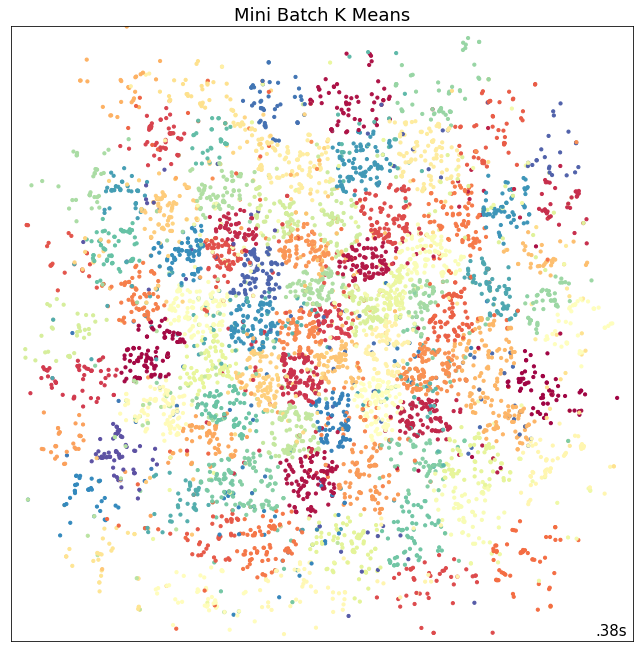

Running Algorithm on Full Data
Estimating Cluster Numbers Using Affinity Propagation


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:08<00:00, 90.82s/it]


Predicted Number of Clusters: 137


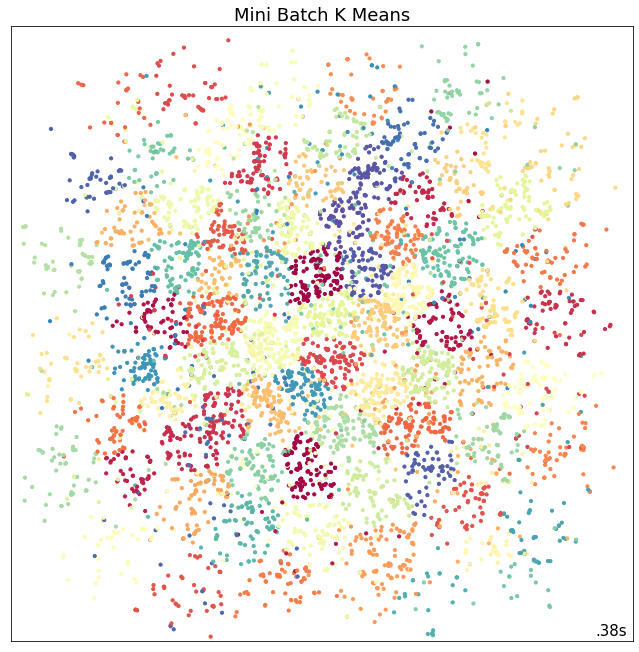

Comparing Cluster Labelling Between Datasets
Rand Score: 0.33031726886872964


In [19]:
##Frequent places visited
X_prepan, y_prepan = frequent_visits(prepan)
X_pan, y_pan = frequent_visits(pan)

#Compare pandemic and prepandemic for frequently visited places
y_pred_prepan, y_labels_prepan, y_pred_pan, y_labels_pan = compare_predictions(X_prepan, y_prepan, X_pan, y_pan, coordinates = True)

Running Algorithm on Full Data
Estimating Cluster Numbers Using Affinity Propagation


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.74s/it]


Predicted Number of Clusters: 132


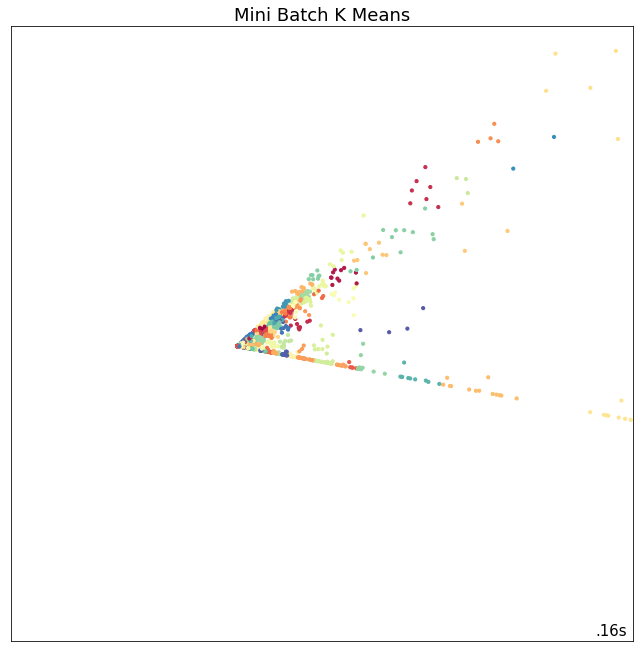

Running Algorithm on Full Data
Estimating Cluster Numbers Using Affinity Propagation


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.81s/it]


Predicted Number of Clusters: 129


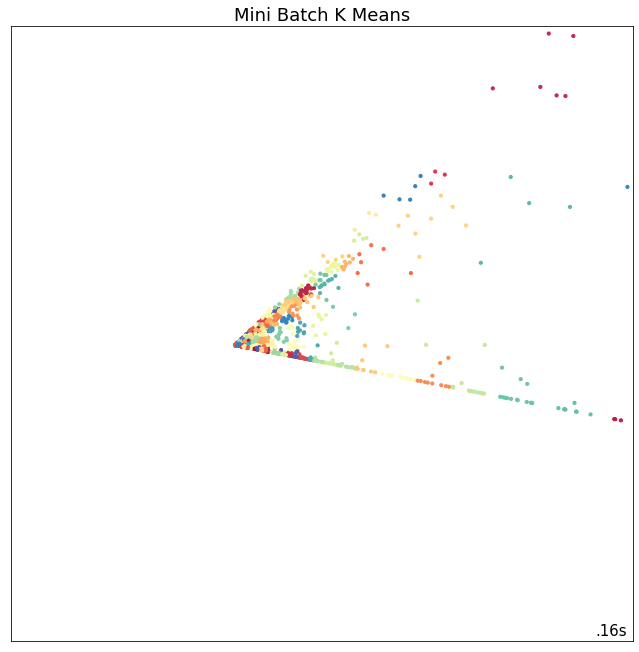

Comparing Cluster Labelling Between Datasets
Rand Score: 0.16628617482763042


In [20]:
##Distance Travelled
X_prepan, y_prepan = distance_travelled(prepan)
X_pan, y_pan = distance_travelled(pan)

#Compare pandemic and prepandemic for distance travelled
y_pred_prepan, y_labels_prepan, y_pred_pan, y_labels_pan = compare_predictions(X_prepan, y_prepan, X_pan, y_pan, coordinates = False)

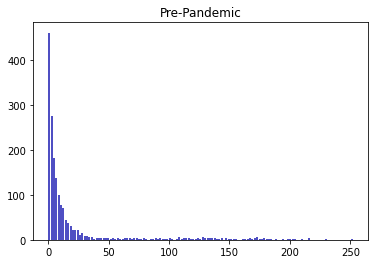

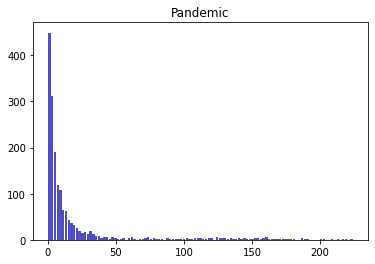

In [21]:
##Histogram of maximum distance
plt.hist(x=X_prepan[X_prepan['maximum_distance'] > 0]['maximum_distance'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pre-Pandemic')
plt.show()

plt.hist(x=X_pan[X_pan['maximum_distance'] > 0]['maximum_distance'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pandemic')
plt.show()

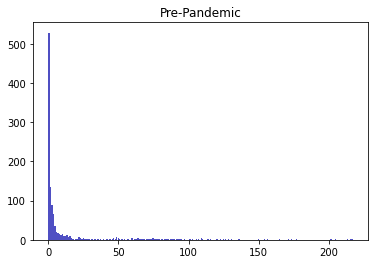

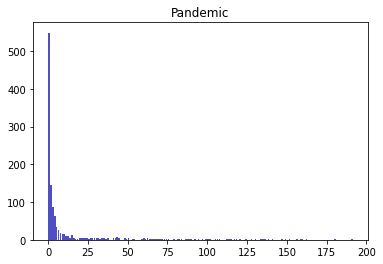

In [22]:
##Histogram of minimum distance
plt.hist(x=X_prepan[X_prepan['minimum_distance'] > 0]['minimum_distance'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pre-Pandemic')
plt.show()

plt.hist(x=X_pan[X_pan['minimum_distance'] > 0]['minimum_distance'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pandemic')
plt.show()

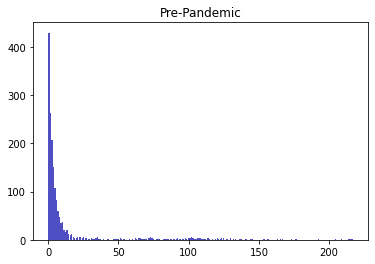

Pre-Pandemic Mean of Mean Distances: 11.551829766668785


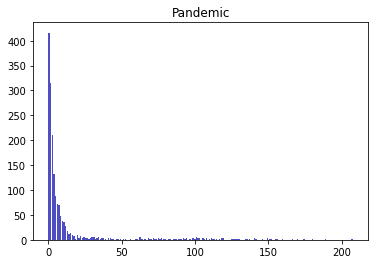

Pandemic Mean of Mean Distances: 11.334816059694857


In [23]:
##Histogram of mean distance
plt.hist(x=X_prepan[X_prepan['mean_distance'] > 0]['mean_distance'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pre-Pandemic')
plt.show()

#Mean of mean distances
print("Pre-Pandemic Mean of Mean Distances: " + str(X_prepan['mean_distance'].mean()))

plt.hist(x=X_pan[X_pan['mean_distance'] > 0]['mean_distance'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pandemic')
plt.show()

#Mean of mean distances
print("Pandemic Mean of Mean Distances: " + str(X_pan['mean_distance'].mean()))

Running Algorithm on Full Data
Estimating Cluster Numbers Using Affinity Propagation


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.10it/s]


Predicted Number of Clusters: 32


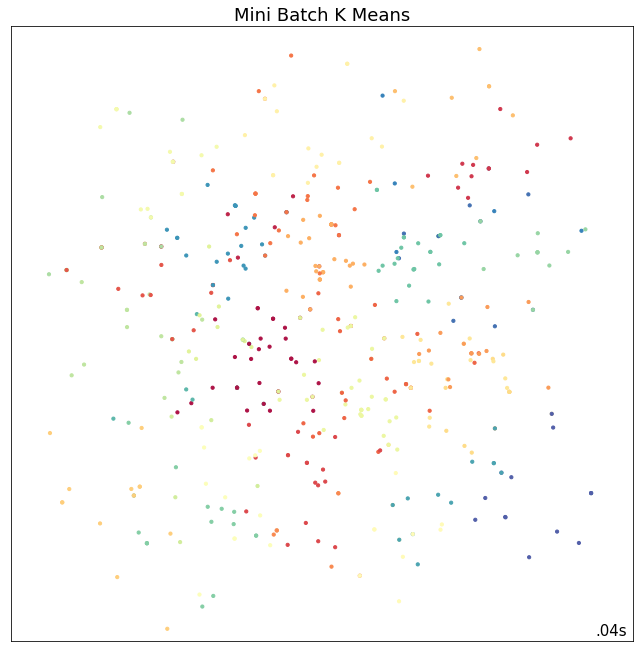

Running Algorithm on Full Data
Estimating Cluster Numbers Using Affinity Propagation


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]

Predicted Number of Clusters: 29


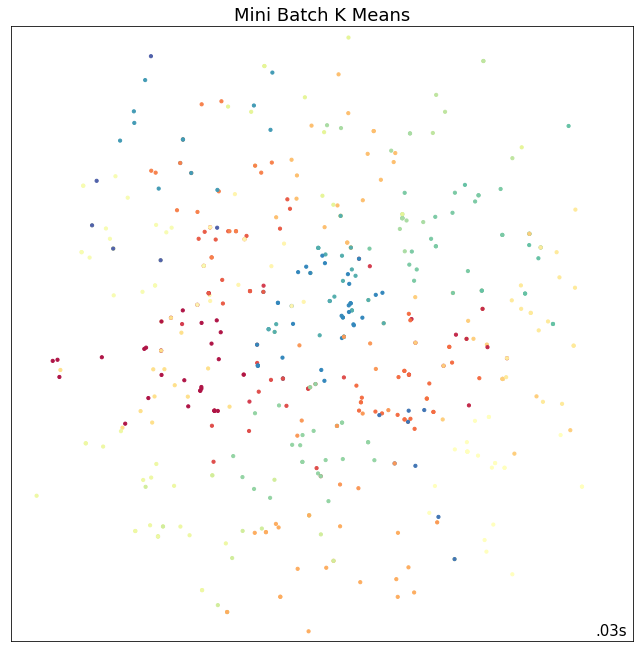

Comparing Cluster Labelling Between Datasets
Rand Score: 0.2515259522318831


In [24]:
##Duration Spent
X_prepan, y_prepan = duration_spent(prepan)
X_pan, y_pan = duration_spent(pan)

#Compare pandemic and prepandemic for duration spent
y_pred_prepan, y_labels_prepan, y_pred_pan, y_labels_pan = compare_predictions(X_prepan, y_prepan, X_pan, y_pan, coordinates = True)

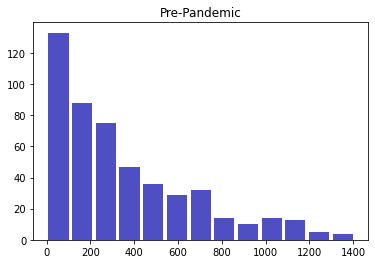

Pre-Pandemic Mean Duration: 353.83459999999997


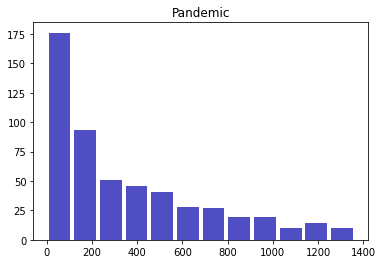

Pandemic Mean Duration: 355.5492834890966


In [25]:
##Histogram of duration
plt.hist(x=X_prepan[X_prepan['duration'] > 0]['duration'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pre-Pandemic')
plt.show()

#Mean of mean distances
print("Pre-Pandemic Mean Duration: " + str(X_prepan['duration'].mean()))

plt.hist(x=X_pan[X_pan['duration'] > 0]['duration'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Pandemic')
plt.show()

#Mean of mean distances
print("Pandemic Mean Duration: " + str(X_pan['duration'].mean()))

In [26]:
# ##Direction travelled
# X_prepan, y_prepan = travel_direction(prepan)
# X_pan, y_pan = travel_direction(pan)

# #Compare pandemic and prepandemic for duration spent
# y_pred_prepan, y_labels_prepan, y_pred_pan, y_labels_pan = compare_predictions(X_prepan, y_prepan, X_pan, y_pan, coordinates = True)

In [27]:
# ##Histogram of direction of travel
# plt.hist(x=X_prepan['direction'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
# plt.title('Pre-Pandemic')
# plt.show()

# plt.hist(x=X_pan['direction'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
# plt.title('Pandemic')
# plt.show()

## Behavioural Patterns

Findings demonstrate there are more frequently visted places pre-pandemic that during the pandemic, with cluster numbers much lower. This shows that the pandemic has had an impact on the number of places visited - most likely due to the restriction and closures put in place. Findings also suggest that there is a change in behaviour from people as a result of the pandemic with the places people visit being quite different between the datasets. Similar to frequently visited places, people appear to travel less distance to visit those places during the pandemic, with a lower mean distance and less frequent longer distances travelled. Time spent at a location also decreased with, with a mean duration spent at a location during the pandemic less than that of pre-pandemic, and a higher frequency of shorter stays during the pandemic.

### Validation of findings and additional ideas

Further validation of the findings could be done by matching evidence of visted places to the labels assigned by the algorithm. Using a small validated dataset could help with this. In terms of next steps, if possible it would be great to use supervised approach, where the model could be trained for longer. I would also incorporate all the behavioural features in a single model to assess whether a multiple freatures are better for the algorithm clustering. In relation to this I would then trial the algorithm with different combinations of features, this may show that certain factors may not be that important in determing mobility patterns or that certain features are key indicators. Comparing how the different features change in the prepandemic and pandemic mobility patterns, i.e. do people spend less time at frequently visited locations or do people only travel at certain times would be of interest